In [74]:
import random
random.seed(112358)

import os
import sys
import re
from tqdm.notebook import tqdm, trange

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf

In [92]:
def winner(df):
    df = df.drop(['Subjectivity', 'Polarity','Year', 'Thread_Democratic', 'Party_Democratic', 'Party_Republican', 'Gender_Male'], axis = 1)
    states = np.unique(df.State.values)
    winner_state = []
    dem_ev, rep_ev = 0, 0
    for state in states:
        avg_state_vote = np.mean(df[df.State == state].Pred_Democrat_Perc)
        if avg_state_vote > 0.5:
            winner_state.append([state, np.mean(df[df.State == state].Electoral_Votes), 0, 'Democratic'])
            dem_ev += np.mean(df[df.State == state].Electoral_Votes)
        else:
            winner_state.append([state, 0, np.mean(df[df.State == state]).Electoral_Votes, 'Republican'])
            rep_ev += np.mean(df[df.State == state].Electoral_Votes)

    if dem_ev > rep_ev:
        winner_state.append(['Final', dem_ev, rep_ev, 'Democratic'])
        final_winner = 'Democratic'
    else:
        winner_state.append(['Final', dem_ev, rep_ev, 'Republican'])
        final_winner = 'Republican'
        
    # df_winner = pd.DataFrame(winner_state, columns = ['State', 'Democratic_EV', 'Republican_EV', 'Winner'])

    return final_winner

In [76]:
df_train = pd.read_csv('prediction_data/sentiment_analysis_summary_train.csv')
df_test = pd.read_csv('prediction_data/sentiment_analysis_summary_test.csv')

df_train_State = pd.get_dummies(df_train.State, prefix='State')
df_train_oh = pd.concat([df_train, df_train_State], axis = 1).drop(['State', 'Electoral_Votes', 'State_Alabama', 'State_Arkansas', 'State_Hawaii', 'State_Indiana', 'State_Mississippi', 'State_Missouri', 'State_Nebraska', 'State_New Hampshire', 'State_Utah'], axis = 1)
df_train_oh = df_train_oh.dropna()

df_test_State = pd.get_dummies(df_test.State, prefix='State')
df_test_oh = pd.concat([df_test, df_test_State], axis = 1).drop(['State', 'Electoral_Votes'], axis = 1)

display(df_train_oh.head(3))
display(df_test_oh.head(3))

x_train = df_train_oh.drop('Democrat_Perc', axis = 1).values
y_train = df_train_oh[['Democrat_Perc']].values

x_test = df_test_oh.drop('Democrat_Perc', axis = 1).values
y_test = df_test_oh[['Democrat_Perc']].values

scalar = MinMaxScaler()
scalar.fit(x_train)

x_train = scalar.transform(x_train)
x_test = scalar.transform(x_test)

,Subjectivity,Polarity,Year,Thread_Democratic,Party_Democratic,Party_Republican,Gender_Male,Democrat_Perc,State_Alaska,State_Arizona,...,State_North Carolina,State_Ohio,State_Oregon,State_Pensylvania,State_South Carolina,State_Tennessee,State_Texas,State_Virginia,State_Washington,State_Wisconsin
0,0.543492,0.264048,1,1,0,0,1,0.504438,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.712560,-0.018774,1,1,0,0,1,0.504438,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.000000,0.000000,1,1,0,0,1,0.504438,0,0,...,0,0,0,0,0,0,0,0,0,0


,Subjectivity,Polarity,Year,Thread_Democratic,Party_Democratic,Party_Republican,Gender_Male,Democrat_Perc,State_Alaska,State_Arizona,...,State_North Carolina,State_Ohio,State_Oregon,State_Pennsylvania,State_South Carolina,State_Tennessee,State_Texas,State_Virginia,State_Washington,State_Wisconsin
0,0.367007,-0.013946,3,1,1,0,1,0.505918,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0.266667,0.145833,3,1,0,1,1,0.649080,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.350000,0.143750,3,1,0,1,1,0.649080,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
correct_models = []

print('l,d,lr,mse')
for i in trange(500):
    l = 10**np.random.uniform(-4, -1)
    d = np.random.uniform(0.00, 0.45)
    lr = 10**np.random.uniform(-4, -1)

    NN_model = tf.keras.Sequential()
    NN_model.add(tf.keras.layers.Dense(100,  activation='linear', input_shape=(x_train.shape[1],)))
    NN_model.add(tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l = l)))
    NN_model.add(tf.keras.layers.Dropout(d))
    NN_model.add(tf.keras.layers.Dense(80, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l = l)))
    NN_model.add(tf.keras.layers.Dropout(d))
    NN_model.add(tf.keras.layers.Dense(80, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l = l)))
    NN_model.add(tf.keras.layers.Dropout(d))
    NN_model.add(tf.keras.layers.Dense(60, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l = l)))
    NN_model.add(tf.keras.layers.Dropout(d))
    NN_model.add(tf.keras.layers.Dense(60, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l = l)))
    NN_model.add(tf.keras.layers.Dropout(d))
    NN_model.add(tf.keras.layers.Dense(40, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l = l)))
    NN_model.add(tf.keras.layers.Dropout(d))
    NN_model.add(tf.keras.layers.Dense(40, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l = l)))
    NN_model.add(tf.keras.layers.Dropout(d))
    NN_model.add(tf.keras.layers.Dense(20, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l = l)))
    NN_model.add(tf.keras.layers.Dropout(d))
    NN_model.add(tf.keras.layers.Dense(20, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l = l)))
    NN_model.add(tf.keras.layers.Dropout(d))
    NN_model.add(tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l = l)))
    NN_model.add(tf.keras.layers.Dropout(d))
    NN_model.add(tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l = l)))
    NN_model.add(tf.keras.layers.Dense(1,  activation='sigmoid'))

    loss_fn = 'mean_squared_error'
    optimizer = tf.keras.optimizers.Adam(lr = lr)

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

    NN_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['mean_squared_error'])

    history = NN_model.fit(x_train, y_train, validation_split=0.3, epochs=100, batch_size = 1024,verbose = 0, callbacks=[callback])

    mean_squared_error = history.history['val_mean_squared_error'][-1]
    print(f'{l},{d},{lr},{mean_squared_error}')

    
    winner_pred_2012 = NN_model.predict(x_test_2012)
    df_2012 = df_train[df_train_oh.Year == 1]
    df_2012['Pred_Democrat_Perc'] = winner_pred_2012

    winner_2012 = winner(df_2012)

    x_test_2016 = df_train_oh[df_train_oh.Year == 2].drop('Democrat_Perc', axis = 1)
    x_test_2016 = scalar.transform(x_test_2016)
    y_test_2016 = df_train_oh[df_train_oh.Year == 2][['Democrat_Perc']].values
    winner_pred_2016 = NN_model.predict(x_test_2016)
    df_2016 = df_train[df_train_oh.Year == 2]
    df_2016['Pred_Democrat_Perc'] = winner_pred_2016

    winner_2016 = winner(df_2016)

    if winner_2012 == 'Democratic' and winner_2016 == 'Republican':
        correct_models.append(NN_model)



l,d,lr,mse


13616,0.04482228617097846,0.010244090110063553
0.0010553959423987226,0.28183545661602766,0.0009196006134538909,0.010214414447546005
0.0011078900889582358,0.09171445043786387,0.0008457038124040096,0.009430419653654099
0.0002739965471907791,0.20077976319470253,0.0022045225446002035,0.010206753388047218
0.09561060665224409,0.4190088669128513,0.003399241402586415,0.010218383744359016
0.004235660591727868,0.2466321165089124,0.004970212419803142,0.010207243263721466
0.03672954170892926,0.21882992184371391,0.00012487864212224134,0.010218298062682152
0.057192437566404034,0.0387441882747645,0.010181740928748326,0.010217331349849701
0.004526785850248703,0.09966452995601642,0.0008282022962088093,0.010206116363406181
0.0005513910601045635,0.1710659766795143,0.012436173248693214,0.010251705534756184
0.00010341081934286072,0.4271164996303981,0.06613253852236438,0.010229210369288921
0.08774049702773032,0.10146558366616325,0.022240353746677384,0.010201744735240936
0.00019239397175361016,0.303747550324

KeyboardInterrupt: 

In [98]:
res_2020 = []
for model in tqdm(correct_models):
    df_2020 = df_test.copy(deep=True)
    df_2020['Pred_Democrat_Perc'] = winner_pred_2020

    winner_2020 = winner(df_2020)
    res_2020.append(winner_2020)

res_2020

['Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican',
 'Republican']

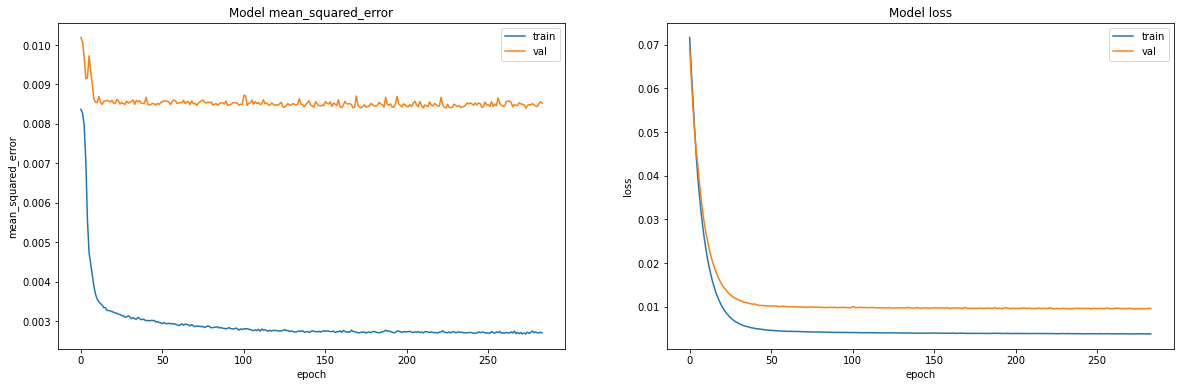

In [86]:
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(history.history['mean_squared_error'])
ax[0].plot(history.history['val_mean_squared_error'])
ax[0].set_title('Model mean_squared_error')
ax[0].set_ylabel('mean_squared_error')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='best')

In [87]:
x_test_2012 = df_train_oh[df_train_oh.Year == 1].drop('Democrat_Perc', axis = 1)
x_test_2012 = scalar.transform(x_test_2012)
y_test_2012 = df_train_oh[df_train_oh.Year == 1][['Democrat_Perc']].values

winner_pred_2012 = NN_model.predict(x_test_2012)
print(f'Mean Squared error = {mean_squared_error(y_test_2012, winner_pred_2012):.5f}')

Mean Squared error = 0.00025


In [88]:
df_2012 = df_train[df_train_oh.Year == 1]
df_2012['Pred_Democrat_Perc'] = winner_pred_2012
df_2012

,Subjectivity,Polarity,State,Electoral_Votes,Year,Thread_Democratic,Party_Democratic,Party_Republican,Gender_Male,Democrat_Perc,Pred_Democrat_Perc
0,0.543492,0.264048,Florida,29,1,1,0,0,1,0.504438,0.504847
1,0.712560,-0.018774,Florida,29,1,1,0,0,1,0.504438,0.504841
2,1.000000,0.000000,Florida,29,1,1,0,0,1,0.504438,0.504558
3,0.294444,0.022222,Texas,38,1,1,0,1,1,0.419888,0.418414
4,0.241667,0.233333,Texas,38,1,1,0,1,1,0.419888,0.418534
...,...,...,...,...,...,...,...,...,...,...,...
12563,0.750000,0.375000,Michigan,16,1,1,0,0,1,0.548019,0.536877
12564,0.000000,0.000000,Texas,38,1,1,1,0,1,0.419888,0.420129
12565,0.702778,0.111806,Michigan,16,1,1,0,0,1,0.548019,0.537073
12566,0.150000,0.100000,Michigan,16,1,1,0,0,1,0.548019,0.537609


In [89]:
winner_2012 = winner(df_2012)
winner_2012

,State,Democratic_EV,Republican_EV,Winner
0,Alabama,0.0,9.0,Republican
1,Alaska,0.0,3.0,Republican
2,Arizona,0.0,11.0,Republican
3,Arkansas,0.0,6.0,Republican
4,California,55.0,0.0,Democratic
5,Colorado,9.0,0.0,Democratic
6,Connecticut,7.0,0.0,Democratic
7,Florida,29.0,0.0,Democratic
8,Georgia,0.0,16.0,Republican
9,Hawaii,0.0,4.0,Republican


In [90]:
x_test_2016 = df_train_oh[df_train_oh.Year == 2].drop('Democrat_Perc', axis = 1)
x_test_2016 = scalar.transform(x_test_2016)
y_test_2016 = df_train_oh[df_train_oh.Year == 2][['Democrat_Perc']].values

winner_pred_2016 = NN_model.predict(x_test_2016)

print(f'Mean Squared error = {mean_squared_error(y_test_2012, winner_pred_2012):.5f}')

df_2016 = df_train[df_train_oh.Year == 2]
df_2016['Pred_Democrat_Perc'] = winner_pred_2016

winner_2016 = winner(df_2016)
winner_2016

Mean Squared error = 0.00025


,State,Democratic_EV,Republican_EV,Winner
0,Alabama,0.000000,17.413043,Republican
1,Alaska,0.000000,9.900000,Republican
2,Arizona,24.074561,0.000000,Democratic
3,Arkansas,0.000000,18.063380,Republican
4,California,36.266142,0.000000,Democratic
5,Colorado,19.523148,0.000000,Democratic
6,Connecticut,18.476190,0.000000,Democratic
7,Florida,24.143240,0.000000,Democratic
8,Georgia,21.251521,0.000000,Democratic
9,Hawaii,0.000000,18.000000,Republican


In [96]:
winner_pred_2020 = NN_model.predict(x_test)

# print(f'Mean Squared error = {mean_squared_error(y_test, winner_pred_2020):.5f}')

df_2020 = df_test.copy(deep=True)
df_2020['Pred_Democrat_Perc'] = winner_pred_2020

winner_2020 = winner(df_2020)
winner_2020

'Republican'